# Random Forest Model Development

This notebook develops and optimizes the Random Forest model using the project's training, model, and metrics modules.

## Objectives
- Hyperparameter optimization with Optuna
- Model evaluation and validation
- Feature importance analysis
- Performance metrics comparison
- Model selection and finalization


In [5]:
# Install required packages if not available
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print(f"✅ {package} installed successfully")
    except Exception as e:
        print(f"⚠️  Could not install {package}: {e}")

# Install pydantic-settings if needed
try:
    import pydantic_settings
    print("✅ pydantic-settings already available")
except ImportError:
    print("Installing pydantic-settings...")
    install_package('pydantic-settings')


✅ pydantic-settings already available


In [6]:
# Import project modules
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Project modules
from pricing_rf.data import load_data, clean_data, get_time_series_cv_splits
from pricing_rf.features import create_feature_pipeline, create_all_features
from pricing_rf.metrics import wape, tail_mae, evaluate_model
from pricing_rf.model import build_rf
from pricing_rf.config import DataConfig
from training.objective import create_objective, create_objective_with_cv

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Data Preparation and Feature Engineering


In [7]:
# Load and prepare data
print("Loading and preparing data...")
raw_data = load_data('../data/raw.csv')
cleaned_data = clean_data(raw_data)

print(f"Raw data shape: {raw_data.shape}")
print(f"Cleaned data shape: {cleaned_data.shape}")

# Create all features
print("Creating all features...")
df_with_features = create_all_features(cleaned_data)
print(f"Data with features shape: {df_with_features.shape}")

# Define categorical and numerical features for the pipeline
categorical_features = ['category_feature']
numerical_features = [col for col in df_with_features.columns 
                     if col not in ['timestamp', 'price', 'category_feature']]

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {len(numerical_features)} features")

# Create feature pipeline
feature_pipeline = create_feature_pipeline(categorical_features, numerical_features)
print(f"Feature pipeline created: {type(feature_pipeline)}")

# Prepare features and target
X = feature_pipeline.fit_transform(df_with_features)
y = df_with_features['price'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names after transformation: {feature_pipeline.get_feature_names_out()}")


Loading and preparing data...
Raw data shape: (10000, 6)
Cleaned data shape: (10000, 6)
Creating all features...
Data with features shape: (10000, 39)
Categorical features: ['category_feature']
Numerical features: 36 features
Feature pipeline created: <class 'sklearn.compose._column_transformer.ColumnTransformer'>
Feature matrix shape: (10000, 39)
Target shape: (10000,)
Feature names after transformation: ['num__feature1' 'num__feature2' 'num__feature3' 'num__year' 'num__month'
 'num__day' 'num__dayofweek' 'num__dayofyear' 'num__week' 'num__quarter'
 'num__month_sin' 'num__month_cos' 'num__dayofweek_sin'
 'num__dayofweek_cos' 'num__timestamp_numeric' 'num__price_lag_1'
 'num__price_lag_7' 'num__price_lag_30' 'num__price_rolling_mean_7'
 'num__price_rolling_std_7' 'num__price_rolling_min_7'
 'num__price_rolling_max_7' 'num__price_rolling_mean_30'
 'num__price_rolling_std_30' 'num__price_rolling_min_30'
 'num__price_rolling_max_30' 'num__price_rolling_mean_90'
 'num__price_rolling_std_90

## 2. Time Series Split for Validation


In [8]:
# Create time series splits
print("Creating time series splits...")
splits = get_time_series_cv_splits(df_with_features, n_splits=5)

print(f"Number of splits: {len(splits)}")
for i, (train_idx, val_idx) in enumerate(splits):
    train_data = df_with_features.iloc[train_idx]
    val_data = df_with_features.iloc[val_idx]
    print(f"Split {i+1}: Train={len(train_data)}, Val={len(val_data)}")
    print(f"  Train date range: {train_data['timestamp'].min()} to {train_data['timestamp'].max()}")
    print(f"  Val date range: {val_data['timestamp'].min()} to {val_data['timestamp'].max()}")

# Use the last split for hyperparameter optimization
train_idx, val_idx = splits[-1]
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print(f"\nFinal split for optimization:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")


Creating time series splits...
Number of splits: 5
Split 1: Train=1670, Val=1666
  Train date range: 2020-01-01 00:00:00 to 2024-07-27 00:00:00
  Val date range: 2024-07-28 00:00:00 to 2029-02-17 00:00:00
Split 2: Train=3336, Val=1666
  Train date range: 2020-01-01 00:00:00 to 2029-02-17 00:00:00
  Val date range: 2029-02-18 00:00:00 to 2033-09-10 00:00:00
Split 3: Train=5002, Val=1666
  Train date range: 2020-01-01 00:00:00 to 2033-09-10 00:00:00
  Val date range: 2033-09-11 00:00:00 to 2038-04-03 00:00:00
Split 4: Train=6668, Val=1666
  Train date range: 2020-01-01 00:00:00 to 2038-04-03 00:00:00
  Val date range: 2038-04-04 00:00:00 to 2042-10-25 00:00:00
Split 5: Train=8334, Val=1666
  Train date range: 2020-01-01 00:00:00 to 2042-10-25 00:00:00
  Val date range: 2042-10-26 00:00:00 to 2047-05-18 00:00:00

Final split for optimization:
Train: 8334 samples
Validation: 1666 samples


## 3. Hyperparameter Optimization with Optuna


In [9]:
# Create Optuna objective using project module
print("Creating Optuna objective...")
objective = create_objective(X_train, y_train, X_val, y_val, primary_metric='wape')

# Create study
study = optuna.create_study(direction='minimize', study_name='pricing_rf_optimization')
print(f"Study created: {study.study_name}")

# Run optimization
print("Starting hyperparameter optimization...")
print("This may take several minutes...")
study.optimize(objective, n_trials=50)

print(f"\nOptimization completed!")
print(f"Number of trials: {len(study.trials)}")
print(f"Best trial: {study.best_trial.number}")
print(f"Best value (WAPE): {study.best_value:.4f}")
print(f"Best params: {study.best_params}")


[I 2025-09-14 17:00:37,955] A new study created in memory with name: pricing_rf_optimization


Creating Optuna objective...
Study created: pricing_rf_optimization
Starting hyperparameter optimization...
This may take several minutes...


[I 2025-09-14 17:00:43,714] Trial 0 finished with value: 1.3713979039739195 and parameters: {'n_estimators': 326, 'max_depth': 22, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 1.3713979039739195.
[I 2025-09-14 17:00:44,144] Trial 1 finished with value: 3.500222771157767 and parameters: {'n_estimators': 123, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.3713979039739195.
[I 2025-09-14 17:00:44,362] Trial 2 finished with value: 3.5642946830248654 and parameters: {'n_estimators': 54, 'max_depth': 43, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.3713979039739195.
[I 2025-09-14 17:00:44,533] Trial 3 finished with value: 3.4721659928016053 and parameters: {'n_estimators': 53, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 1.371397903973919


Optimization completed!
Number of trials: 50
Best trial: 12
Best value (WAPE): 1.0773
Best params: {'n_estimators': 490, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


## 4. Model Evaluation and Analysis


In [10]:
# Train best model
print("Training best model...")
best_model = build_rf(**study.best_params)
best_model.fit(X_train, y_train)

# Make predictions
y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_val)

# Calculate metrics using project modules
print("\nTraining Metrics:")
train_wape = wape(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
print(f"WAPE: {train_wape:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nValidation Metrics:")
val_wape = wape(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)
print(f"WAPE: {val_wape:.4f}")
print(f"MAE: {val_mae:.4f}")
print(f"R²: {val_r2:.4f}")

# Calculate tail MAE
train_tail_mae = tail_mae(y_train, y_pred_train, percentile=90)
val_tail_mae = tail_mae(y_val, y_pred_val, percentile=90)
print(f"\nTail MAE (90th percentile):")
print(f"Train: {train_tail_mae:.4f}")
print(f"Validation: {val_tail_mae:.4f}")


Training best model...

Training Metrics:
WAPE: 0.3653
MAE: 0.4501
R²: 0.9992

Validation Metrics:
WAPE: 1.0773
MAE: 1.6152
R²: 0.9800

Tail MAE (90th percentile):
Train: 0.9604
Validation: 6.3415


## 5. Feature Importance Analysis


Top 10 Most Important Features:
                       feature  importance
33           num__price_diff_7    0.341295
18   num__price_rolling_mean_7    0.226589
35          num__price_diff_30    0.099111
31           num__price_diff_1    0.095584
30     num__price_pct_change_1    0.076893
15            num__price_lag_1    0.062008
21    num__price_rolling_max_7    0.041183
20    num__price_rolling_min_7    0.019831
25   num__price_rolling_max_30    0.006336
22  num__price_rolling_mean_30    0.006070


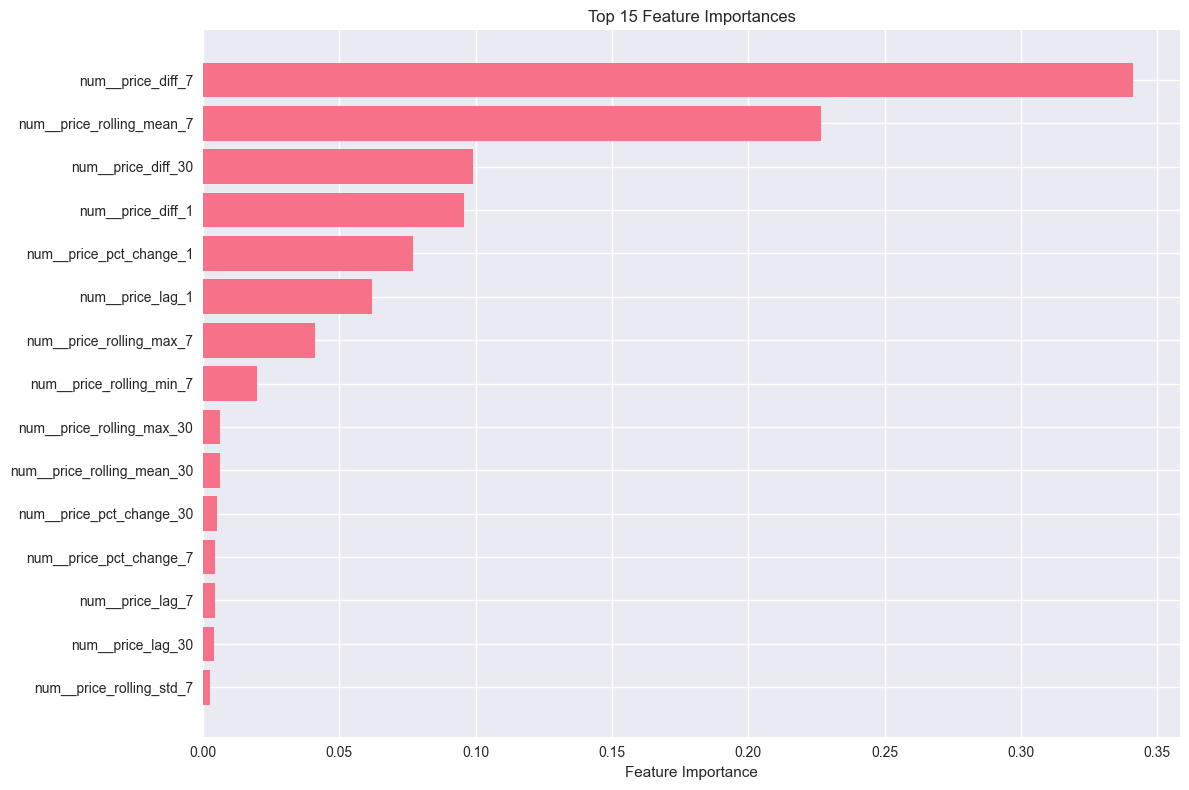


Feature Importance Statistics:
Mean importance: 0.0256
Std importance: 0.0666
Max importance: 0.3413
Min importance: 0.0000


In [11]:
# Feature importance analysis
feature_names = feature_pipeline.get_feature_names_out()
feature_importance = best_model.feature_importances_

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Feature importance statistics
print(f"\nFeature Importance Statistics:")
print(f"Mean importance: {feature_importance.mean():.4f}")
print(f"Std importance: {feature_importance.std():.4f}")
print(f"Max importance: {feature_importance.max():.4f}")
print(f"Min importance: {feature_importance.min():.4f}")


## 6. Cross-Validation Analysis


Running cross-validation...
Fold 1: WAPE = 2.1770
Fold 2: WAPE = 1.6661
Fold 3: WAPE = 1.1497
Fold 4: WAPE = 1.2329
Fold 5: WAPE = 1.0773

Cross-Validation Results:
Mean WAPE: 1.4606
Std WAPE: 0.4125
Min WAPE: 1.0773
Max WAPE: 2.1770


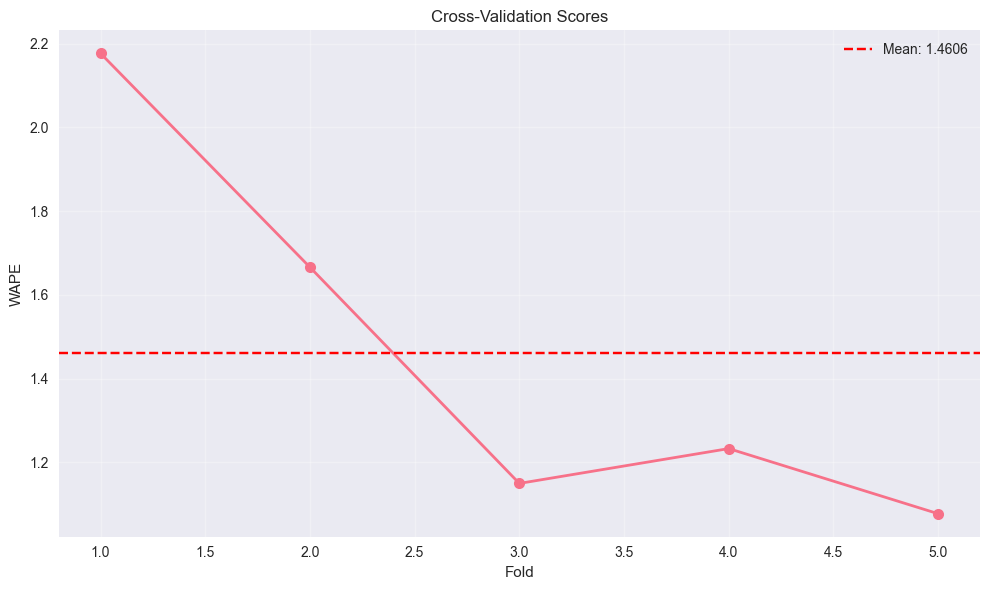

In [12]:
# Cross-validation using time series splits
print("Running cross-validation...")

# Create CV objective
cv_objective = create_objective_with_cv(X, y, splits, primary_metric='wape')

# Run CV
cv_scores = []
for i, (train_idx, val_idx) in enumerate(splits):
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_val_cv = X[val_idx]
    y_val_cv = y[val_idx]
    
    # Train model
    model_cv = build_rf(**study.best_params)
    model_cv.fit(X_train_cv, y_train_cv)
    
    # Predict and score
    y_pred_cv = model_cv.predict(X_val_cv)
    score = wape(y_val_cv, y_pred_cv)
    cv_scores.append(score)
    
    print(f"Fold {i+1}: WAPE = {score:.4f}")

# CV statistics
cv_scores = np.array(cv_scores)
print(f"\nCross-Validation Results:")
print(f"Mean WAPE: {cv_scores.mean():.4f}")
print(f"Std WAPE: {cv_scores.std():.4f}")
print(f"Min WAPE: {cv_scores.min():.4f}")
print(f"Max WAPE: {cv_scores.max():.4f}")

# Plot CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, 'o-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('WAPE')
plt.title('Cross-Validation Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Model Summary and Next Steps


In [13]:
# Model summary
print("=== MODEL DEVELOPMENT SUMMARY ===")
print(f"Best hyperparameters: {study.best_params}")
print(f"Best validation WAPE: {study.best_value:.4f}")
print(f"Cross-validation mean WAPE: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Final validation WAPE: {val_wape:.4f}")
print(f"Final validation R²: {val_r2:.4f}")

print(f"\n=== FEATURE INSIGHTS ===")
print(f"Total features: {len(feature_names)}")
print(f"Top 5 features:")
for i, (_, row) in enumerate(importance_df.head(5).iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\n=== NEXT STEPS ===")
print("1. Save the best model and feature pipeline")
print("2. Register model in MLflow")
print("3. Deploy model to production")
print("4. Set up monitoring and drift detection")
print("5. Create model retraining pipeline")

# Save model artifacts
print(f"\n=== SAVING MODEL ARTIFACTS ===")
import joblib
import os

# Create artifacts directory
os.makedirs('../artifacts', exist_ok=True)

# Save model
joblib.dump(best_model, '../artifacts/best_model.pkl')
print("✓ Model saved to artifacts/best_model.pkl")

# Save feature pipeline
joblib.dump(feature_pipeline, '../artifacts/feature_pipeline.pkl')
print("✓ Feature pipeline saved to artifacts/feature_pipeline.pkl")

# Save feature names
with open('../artifacts/feature_names.txt', 'w') as f:
    for name in feature_names:
        f.write(f"{name}\n")
print("✓ Feature names saved to artifacts/feature_names.txt")

print("\n🎉 Model development completed successfully!")


=== MODEL DEVELOPMENT SUMMARY ===
Best hyperparameters: {'n_estimators': 490, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
Best validation WAPE: 1.0773
Cross-validation mean WAPE: 1.4606 ± 0.4125
Final validation WAPE: 1.0773
Final validation R²: 0.9800

=== FEATURE INSIGHTS ===
Total features: 39
Top 5 features:
  1. num__price_diff_7: 0.3413
  2. num__price_rolling_mean_7: 0.2266
  3. num__price_diff_30: 0.0991
  4. num__price_diff_1: 0.0956
  5. num__price_pct_change_1: 0.0769

=== NEXT STEPS ===
1. Save the best model and feature pipeline
2. Register model in MLflow
3. Deploy model to production
4. Set up monitoring and drift detection
5. Create model retraining pipeline

=== SAVING MODEL ARTIFACTS ===
✓ Model saved to artifacts/best_model.pkl
✓ Feature pipeline saved to artifacts/feature_pipeline.pkl
✓ Feature names saved to artifacts/feature_names.txt

🎉 Model development completed successfully!


# Random Forest Model Development

This notebook develops and evaluates the Random Forest pricing model:
- Model training and validation
- Hyperparameter optimization
- Feature importance analysis
- Model evaluation and metrics
- Cross-validation results
